In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")

In [ ]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [ ]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

## Loss

$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

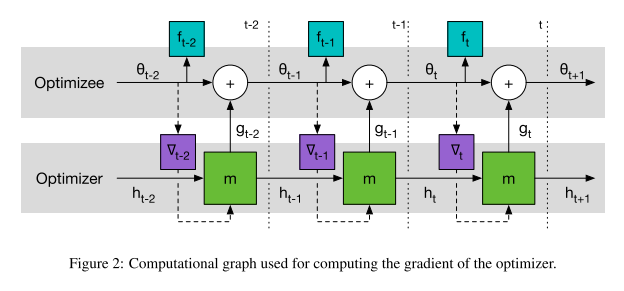

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

This section is phrased in a way that is a bit confusing to me, but I think it is actually quite simple: what it means is simply this: every single "*coordinate*" has its own state (though the optimizer itself is shared), and information is not shared across coordinates.

The thing I am not 100% sure about is what a "coordinate" is supposed to be. My guess, however, is that it is simply a weight or a bias. In other words, if we have a network with 100 weights and biases, there will be 100 hidden states involved in optimizing it, which means that effectively there will be 100 instances of our optimizer network running in parallel as we optimize.

# Implementation

- As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.
- We can't really **update** the parameters of the optimizee in place. Pytorch would not allow it because it can't backpropagate through these updates afterwards. Instead, at each iteration we create a new optimizee with the updated parameters. This means that every single optimizee must be able to take a list of parameters as an argument and use them instead of reinitialize from scratch. This also means that the optimizee can't use convenient Pytorch abstractions like nn.Linear, because these will not support setting the weights in a way that does not lose the computational graph for where the weights come from. Because of this, our implementation of the MNIST network will use tensor variable directly instead of actual neural net layers. The optimizee class has to support a method called `all_named_parameters` which is essentially the same thing as `named_parameters` in Pytorch but without the params needing to actually be of `Parameter` class (because the second time around they are of `Variable` class).

In [ ]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    
    """Arguments: opt_net (the optimizer), meta_opt (the optimizer of the optimizer, ie Adam),
    target (the optimizee's target), optimizee_class (the optimizee network class)
    and n_params (simply a convenience, the number of coordinates used by the optimizee)."""
    
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))
    
    # Creation of zero'ed out hidden and cell states (LSTM needs both).
    
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()                            # Zero grad in pytorch
    all_losses = None
    for iteration in range(1, optim_it + 1):            # We run for 100 iterations, as specified in the paper.
        loss = optimizee(target)
                
        # Add to the running loss.
        
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        
        # Get the optimizee's gradients. We retain the graph because we'll need to run
        # backprop again when we optimize the optimizer.
        
        loss.backward(retain_graph = should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            
            # We do this so the gradients are disconnected from the graph but we still get gradients from the rest
            
            gradients = detach_var(p.grad.view(cur_sz, 1))
            
            # Call the optimizer.
            
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            
            # Perform the various updates.
            
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            
            # The resulting variable isn't a leaf, which means it won't retain grads by default. Force that.
            
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
            
            # Clear the loss
            
            all_losses = None
            
            # Detach the state variables
            
            optimizee = w(target_to_opt(**{k: detach_var(v) for k, v in result_params.items()}))
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            
            # Otherwise, just create the next optimizee object.
            
            optimizee = w(target_to_opt(**result_params))
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  


# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [ ]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        
        # Note: assuming the same optimization for theta as for the function to find out itself.
        
        if theta is None:
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
        
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
           
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means the gradients won't propagate through inp. This
            # should be ok because the algorithm involves making sure that inp is already detached.
            
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

The experiment below on the various learning rates show that 0.003 is a promising learning rate (it is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer). We train our final model using 0.003.

In [ ]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])
    
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

Now we need to find the best learning rate for the various comparison optimizers. We end up finding 0.1 for Adam, 0.03 for RMSprop, 0.01 for SGD and 0.01 for SGD with nesterov momentum (aka NAG).

In [ ]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [ ]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

In [ ]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

Finally we plot the learning curve for LSTM vs the different alternatives. For reference, the plot in the paper looks like this:

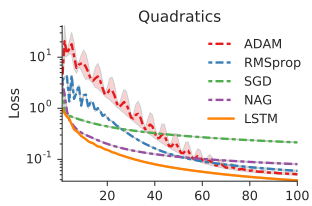


In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [ ]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            './mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
        
        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(nn.Module):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()
        
        # Sadly this network needs to be implemented without using the convenient pytorch abstractions such as 
        # nn.Linear, because afaik there is no way to load parameters in those in a way that preserves gradients.
        
        if kwargs != {}:
            self.params = kwargs
        else:
            inp_size = 28*28
            self.params = {}
            for i in range(n_layers):
                self.params[f'mat_{i}'] = nn.Parameter(torch.randn(inp_size, layer_size) * 0.001) # TODO: use a better initialization
                self.params[f'bias_{i}'] = nn.Parameter(torch.zeros(layer_size))
                inp_size = layer_size

            self.params['final_mat'] = nn.Parameter(torch.randn(inp_size, 10) * 0.001) # TODO:init
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
                
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        
        cur_layer = 0
        while f'mat_{cur_layer}' in self.params:
            inp = self.activation(torch.matmul(inp, self.params[f'mat_{cur_layer}']) + self.params[f'bias_{cur_layer}'])
            cur_layer += 1
                    
        inp = F.log_softmax(torch.matmul(inp, self.params['final_mat']) + self.params['final_bias'], dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.01) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])
    
    
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=50, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

We find the best learning rates for the competitors...

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

And plot! for context, the graph in the original paper looks like this:

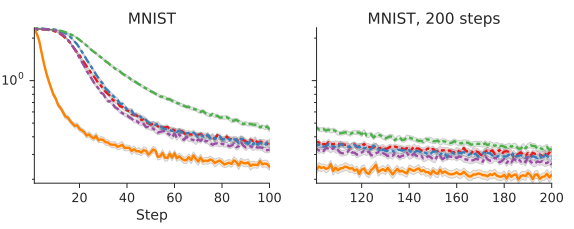

Again we get similar results!!!

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [ ]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

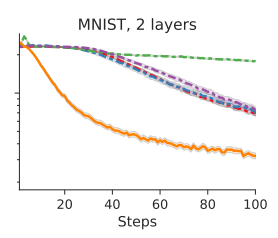

In [ ]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
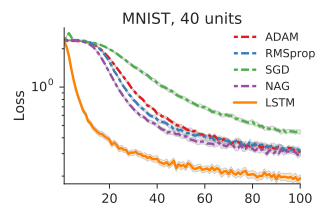

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
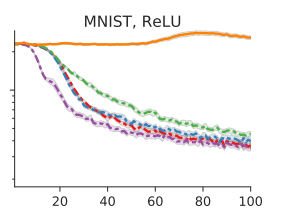

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()